In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Edmunds scrapping - Selenium

In [ ]:
# Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime and set GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one. 
# The above line deletes all files and folders from the current VM and allocates a new one.

#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import pandas as pd
from datetime import datetime as dt
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
def get_web_page_details(url, page):
    
    wd.get(url + page)
    
    date_posted_list = []
    comments_list = []

    databox_comments_div = wd.find_element_by_xpath("//div[@class='DataBox DataBox-Comments']//ul")
#     li_el_list = databox_comments_div.find_elements_by_tag_name('li')
    li_el_list = databox_comments_div.find_elements_by_xpath("li[contains(@class,'Item')]")
    print(len(li_el_list))
    for el in li_el_list:
        blq_len = 0
        try:
            blq_len = len(el.find_element_by_xpath(".//blockquote[@class='UserQuote blockquote']").text)
        except NoSuchElementException as e:
            pass
        
        # print(el.get_attribute('id'))
        comment = el.find_element_by_xpath(".//div[@class='Message userContent']").text[blq_len:].strip('\n ')
        
        date_posted = el.find_element_by_xpath(".//time").get_attribute("datetime").split('+')[0]
        
        # print(date_posted)
        
        # print("\n")

        date_posted_list.append(str(dt.strptime(date_posted, "%Y-%m-%dT%H:%M:%S")))
        comments_list.append(comment)
    
    return date_posted_list, comments_list

In [ ]:
wd = webdriver.Chrome('chromedriver',options=chrome_options)
url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"

In [ ]:
url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"

comments_df = pd.DataFrame(columns = ['date', 'comment'])
for i in range(1,436):
    page = "/p" + str(i)
    if i==1:
        page = ''
    
    print("Scrapping page :", i)
    date_posted_list, comments_list = get_web_page_details(url, page)
#     print(len(date_posted_list), "dates found !", len(comments_list), "comments found!")
    
    df = pd.DataFrame({
        'date' : date_posted_list,
        'comment' : comments_list
    })
    
    comments_df = comments_df.append(df)

In [ ]:
from google.colab import files
comments_df.to_csv('comments_data_complete.csv', index=False)
files.download("comments_data_complete.csv")

In [ ]:
comments_df.shape

## Data read

In [2]:
# reading the data
data = pd.read_csv('scrapper/comments_data_complete.csv')

# removing nulls
data = data.dropna().reset_index(drop=True)
data.isnull().sum()

# taking latest 5000 comments only
data = data.tail(5000)
data.reset_index(drop=True, inplace=True)

# lowering the comment for consistency
data['comment'] = data['comment'].str.lower()
data.head()

,date,comment
0,2/26/2014 21:51,"'02 rx300. gonna sit back, smell the oil and c..."
1,2/27/2014 2:45,@markcincinnati - like i mentioned i got the 1...
2,2/27/2014 2:57,@stickguy i like the new feature to add pix- b...
3,2/27/2014 14:59,"@sweendogy: i read an article about the ""indiv..."
4,2/27/2014 15:08,my wife's mazda cx-7 does that as well ... wil...


In [3]:
data.shape

(5000, 2)

## Task A - Ziff's law

In [4]:
# creating the text from comments 
text = ' '.join(data['comment'].tail(5000))
text = text.lower()

# setting top 'N' words for ziff's law
rank_limit = 100

text[:150]

"'02 rx300. gonna sit back, smell the oil and chill. researching a second opinion. wife wants at least another 4 years/40k miles out of it for kids to "

In [5]:
# tokenizing words from latest 5000 comments for ziffs law
!pip install nltk
import nltk
nltk.download('punkt')
from nltk import word_tokenize, Counter
text_token = word_tokenize(text)
text_token_counter = Counter(text_token)
text_token_counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Counter({"'02": 7,
         'rx300': 3,
         '.': 21189,
         'gon': 31,
         'na': 52,
         'sit': 43,
         'back': 530,
         ',': 22281,
         'smell': 6,
         'the': 24385,
         'oil': 200,
         'and': 9952,
         'chill': 3,
         'researching': 4,
         'a': 11626,
         'second': 130,
         'opinion': 69,
         'wife': 327,
         'wants': 66,
         'at': 2539,
         'least': 407,
         'another': 307,
         '4': 294,
         'years/40k': 1,
         'miles': 527,
         'out': 1104,
         'of': 7487,
         'it': 6815,
         'for': 4775,
         'kids': 35,
         'to': 10165,
         'use': 242,
         'big': 322,
         'grocery': 5,
         'runs': 21,
         'bjs': 1,
         '...': 688,
         'my': 3117,
         'guess': 204,
         'is': 6524,
         'ai': 26,
         "n't": 2988,
         'make': 533,
         'that': 6142,
         'far': 259,
         'without': 219,
 

In [6]:
# creating dataframe for frequency table
text_token_df = pd.DataFrame(data=None, columns=['words', 'frequency'])
text_token_df['words'] = text_token_counter.keys()
text_token_df['frequency'] = text_token_counter.values()

In [7]:
# sorting the text token df and getting ranks
text_token_df.sort_values('frequency', inplace=True, ascending=False)
text_token_df.reset_index(drop=True, inplace=True)
text_token_df['rank'] = text_token_df['frequency'].rank(method='min', ascending=False).astype(int)
text_token_df.head()

,words,frequency,rank
0,the,24385,1
1,",",22281,2
2,.,21189,3
3,a,11626,4
4,i,11120,5


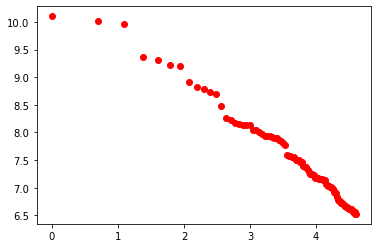

In [8]:
# Add frequency and rank plot for complete corpus

import collections
import scipy.stats as ss
import math

def generateZipfsPlot(comments, n = 100):
   
    # Default is top 100 words
   
    tokens = word_tokenize(comments)
   
    word_count = collections.Counter(tokens)
   
    if n is None:
        word_count_top_n = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))
    else:
        word_count_top_n = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True)[:n])
    word_rank_top_n = ss.rankdata([word_count_top_n[w] for w in word_count_top_n], method = 'min')
   
    l = len(word_count_top_n)
    rev = [l-r+1 for r in word_rank_top_n]
   
    plt.plot([math.log(c) for c in rev], [math.log(word_count_top_n[w]) for w in word_count_top_n], 'ro')
#     plt.plot([math.log(word_count_top_n[w]) for w in word_count_top_n],[math.log(c) for c in rev], 'ro')

generateZipfsPlot(text)

In [9]:
# tranforming frequenct and rank to x & y variables
last_freq = text_token_df.loc[:rank_limit, 'frequency'].min()
n = rank_limit
print(last_freq, n)

y = np.log(text_token_df.loc[:rank_limit, 'rank'])
x = np.log(text_token_df.loc[:rank_limit, 'frequency']/n/last_freq)
df = pd.DataFrame(data={'x': x, 'y':y})

674 100


In [10]:
# hypothesis testing using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(df[['x']], df['y'])
lr_model.coef_, r2_score(df['y'], lr_model.predict(df[['x']]))


(array([-1.0094641]), 0.9765816888954769)

In [11]:
# hypothesis testing using linear regression
import statsmodels.api as sm
model = sm.OLS(y, x)
results = model.fit()
results.conf_int()

,0,1
frequency,-1.016996,-1.001933


Text(0.5, 1.0, 'Ziff"s law')

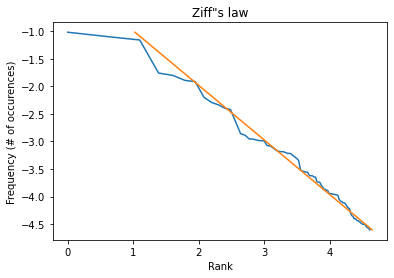

In [12]:
# plotting as per ziffs law
from matplotlib import pyplot as plt
plt.plot(y, x)
plt.plot(lr_model.predict(df[['x']]), x)
plt.xlabel('Rank')
plt.ylabel('Frequency (# of occurences)')
plt.title('Ziff"s law')

## Task B - Find top 10 Brands

### Cleaning brand file

In [13]:
# reading brand file
brand = pd.read_csv('car models and brands.csv')
print(brand.head())
print(brand['Brand'].unique())

# removing non brand words
non_brand_words = ['car', 'problem', 'seat', 'sedan']
mask1 = ~brand['Brand'].isin(non_brand_words)
brand = brand[mask1]

# correcting duplicates - hyundai
mask2 = brand['Brand'].isin(['hyndai kia', 'hyundai', 'hyundai,', 'hyundai.'])
brand.loc[mask2, 'Brand'] = 'hyundai'

# correcting duplicates - kia
mask3 = brand['Brand'].isin(['kia', 'kia,', 'kia.'])
brand.loc[mask3, 'Brand'] = 'kia'

# correcting duplicates - mercedes
mask4 = brand['Brand'].isin(['mercedes', 'mercedes benz', 'mercedes-benz'])
brand.loc[mask4, 'Brand'] = 'mercedes'

# correcting duplicates - nissan
mask5 = brand['Brand'].isin(['nissan', 'nissan.'])
brand.loc[mask5, 'Brand'] = 'nissan'

# correcting duplicates - toyota
mask6 = brand['Brand'].isin(['toyata', 'toyota'])
brand.loc[mask6, 'Brand'] = 'toyota'

# correcting duplicates - volkswagen
mask7 = brand['Brand'].isin(['volkswagen', 'volkwagen'])
brand.loc[mask7, 'Brand'] = 'volkswagen'

# dropping duplicates
brand.drop_duplicates(inplace=True)

# removing models with two brands
model_brand_count = brand['Model'].value_counts()
models_to_remove = model_brand_count[model_brand_count > 1].index
brand = brand[~brand['Model'].isin(models_to_remove)]

print(brand['Brand'].unique())

   Brand    Model
0  acura  integra
1  acura   legend
2  acura    vigor
3  acura      rlx
4  acura      ilx
['acura' 'audi' 'bmw' 'buick' 'cadillac' 'car' 'chevrolet' 'chrysler'
 'dodge' 'ford' 'honda' 'hyndai kia' 'hyundai' 'hyundai,' 'hyundai.'
 'infiniti' 'kia' 'kia,' 'kia.' 'lincoln' 'mazda' 'mercedes'
 'mercedes benz' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'nissan.'
 'pontiac' 'problem' 'saturn' 'seat' 'sedan' 'subaru' 'suzuki' 'toyata'
 'toyota' 'volkswagen' 'volkwagen' 'volvo']
['acura' 'audi' 'bmw' 'buick' 'cadillac' 'chevrolet' 'chrysler' 'dodge'
 'ford' 'honda' 'hyundai' 'infiniti' 'kia' 'lincoln' 'mazda' 'mercedes'
 'mercury' 'mitsubishi' 'nissan' 'pontiac' 'saturn' 'subaru' 'suzuki'
 'toyota' 'volkswagen' 'volvo']


### Top 10 brands

         Brand  frequency
1         audi       2132
2          bmw       1965
0        acura       1018
9        honda        788
15    mercedes        573
24  volkswagen        474
4     cadillac        406
11    infiniti        370
10     hyundai        336
23      toyota        287


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

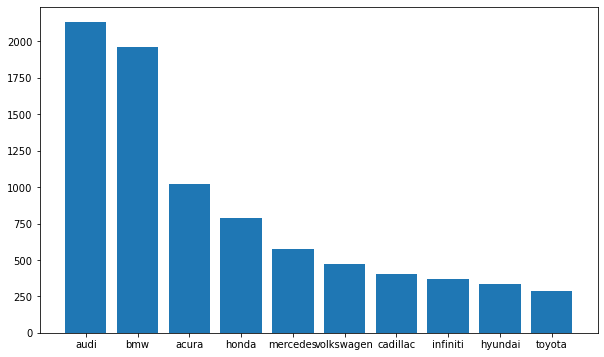

In [14]:
# getting stopword list from nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

# removing stop words from word lists
mask1 = ~text_token_df['words'].isin(stopwords_list)
token_cleaned_df = text_token_df[mask1]

# removing punctuations
import string
mask2 = ~token_cleaned_df['words'].isin(list(string.punctuation))
token_cleaned_df = token_cleaned_df[mask2]

# getting brand frequency
mask3 = token_cleaned_df['words'].isin(brand['Brand'])
brand_freq = token_cleaned_df[mask3]
brand_freq = brand_freq[['words', 'frequency']]
brand_freq.columns = ['Brand', 'frequency']

# getting brand frequency from model frequency
car_freq = token_cleaned_df.merge(brand, right_on='Model', left_on='words')
brand_model_freq = car_freq.groupby('Brand')['frequency'].sum().reset_index()

# concating 
brand_freq_all = pd.concat([brand_freq, brand_model_freq], axis=0)
brand_freq_all = brand_freq_all.groupby('Brand')['frequency'].sum().reset_index()
brand_freq_all.sort_values(ascending=False, inplace=True, by='frequency')

# top 10 brands
top10_brands = brand_freq_all.head(10)
print(top10_brands)

plt.figure(figsize=(10, 6))
plt.bar(top10_brands['Brand'], top10_brands['frequency'])

## Task C - Brand-Brand Lift

Steps to get brand-brand lift
1. create columns with brand names
2. look for 'brand' name in comment from data df

In [15]:
car_freq

,words,frequency,rank,Brand,Model
0,a3,327,201,audi,a3
1,a4,312,215,audi,a4
2,accord,249,254,honda,accord
3,vw,236,267,volkswagen,vw
4,mercedes,226,279,mercedes,mercedes
...,...,...,...,...,...
207,qx70,1,10995,infiniti,qx70
208,iq,1,10995,toyota,iq
209,pacifica,1,10995,chrysler,pacifica
210,sonatas,1,10995,hyundai,sonatas


In [16]:
# creating brand wise columns to get occurence into a dataframe
brand_occurence_df = pd.DataFrame(np.zeros((data.shape[0], 10)))
brand_occurence_df.columns = top10_brands['Brand'].values

# appending comment df with brand occurence df
brand_occurence_df = pd.concat([data, brand_occurence_df], axis=1)

# geting occurence columns populated
for c in brand_occurence_df.iloc[:, 2:]:
    model_list = list(car_freq.loc[car_freq['Brand'] == c, 'words']) + [c]
    print('calculating occurence in comment for brand - ', c, model_list)
    
#     brand_occurence_df[c] = brand_occurence_df['comment'].str.contains(c)
    brand_occurence_df[c] = brand_occurence_df['comment'].str.findall('( ' + '|'.join(model_list) + ' )').\
        astype(bool).astype(int)

print(brand_occurence_df.head())

calculating occurence in comment for brand -  audi ['a3', 'a4', 'a6', 'quattro', 'q5', 'a8', 'a7', 'q3', 'a5', 'q7', 'audi']
calculating occurence in comment for brand -  bmw ['bmws', '328i', '3-series', 'm3', '335i', 'xdrive', '5-series', 'm5', '4-series', 'm6', '535i', '3er', '335d', '528i', '5er', 'alpina', '128i', '640i', 'bmw']
calculating occurence in comment for brand -  acura ['ilx', 'rdx', 'tsx', 'mdx', 'rlx', 'integra', 'rsx', 'acura']
calculating occurence in comment for brand -  honda ['accord', 'city', 'civic', 'pilot', 'nsx', 'cr-v', 'accords', 'hondas', 'exl', 'prelude', 'ex-l', 'crv', 'stream', 'jazz', 'amaze', 'shuttle', 'odyssey', 'spike', 'insight', 'honda']
calculating occurence in comment for brand -  mercedes ['mercedes', 'benz', 'c-class', 'e-class', 'mercedes-benz', 's-class', 'mercedes']
calculating occurence in comment for brand -  volkswagen ['vw', 'golf', 'gti', 'passat', 'jetta', 'sportwagen', 'tiguan', 'beetle', 'vws', 'passats', 'rabbit', 'volkswagen']
ca

audi          861
bmw           976
acura         476
honda         541
mercedes      235
volkswagen    261
cadillac      180
infiniti      200
hyundai       192
toyota        314
dtype: int64


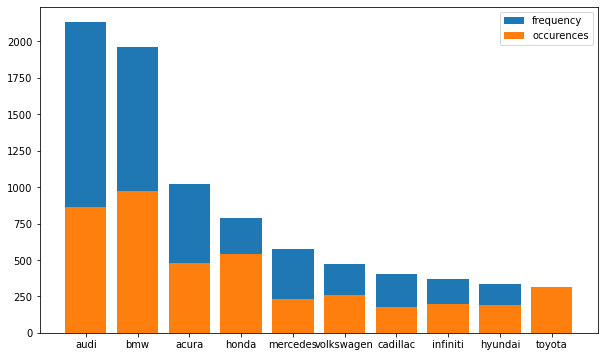

In [17]:
# CHECK
# testing the total occurence by brand in comments vs total frequency in complete text 
comment_mentions = brand_occurence_df.iloc[:, 2:].sum()
print(comment_mentions)

plt.figure(figsize=(10, 6))
plt.bar(top10_brands['Brand'], top10_brands['frequency'], label='frequency')
plt.bar(comment_mentions.index, comment_mentions, label='occurences')
plt.legend()

In [18]:
# getting required packages for lift calc
!pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [19]:
# generating lifts
brand_apriori = apriori(brand_occurence_df.iloc[:, 2:], min_support=0.000001, use_colnames=True)
rules = association_rules(brand_apriori, metric="lift", min_threshold=0)

# cleaning to get one brand to another brand lift
mask1 = rules['antecedents'].map(lambda row: len(row)) == 1
mask2 = rules['consequents'].map(lambda row: len(row)) == 1
rules_one_brand = rules[(mask1 & mask2)]

# converting columns data types
rules_one_brand['antecedents'] = rules_one_brand['antecedents'].map(lambda row: list(row)[0])
rules_one_brand['consequents'] = rules_one_brand['consequents'].map(lambda row: list(row)[0])

rules_one_brand

<ipython-input-19-a3e753b55a61>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_one_brand['antecedents'] = rules_one_brand['antecedents'].map(lambda row: list(row)[0])
<ipython-input-19-a3e753b55a61>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_one_brand['consequents'] = rules_one_brand['consequents'].map(lambda row: list(row)[0])


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,bmw,audi,0.1952,0.1722,0.0604,0.309426,1.796900,0.026787,1.198713
1,audi,bmw,0.1722,0.1952,0.0604,0.350755,1.796900,0.026787,1.239594
2,acura,audi,0.0952,0.1722,0.0356,0.373950,2.171600,0.019207,1.322258
3,audi,acura,0.1722,0.0952,0.0356,0.206736,2.171600,0.019207,1.140604
4,honda,audi,0.1082,0.1722,0.0354,0.327172,1.899953,0.016768,1.230329
...,...,...,...,...,...,...,...,...,...
85,infiniti,hyundai,0.0400,0.0384,0.0032,0.080000,2.083333,0.001664,1.045217
86,toyota,infiniti,0.0628,0.0400,0.0054,0.085987,2.149682,0.002888,1.050314
87,infiniti,toyota,0.0400,0.0628,0.0054,0.135000,2.149682,0.002888,1.083468
88,hyundai,toyota,0.0384,0.0628,0.0066,0.171875,2.736863,0.004188,1.131713


In [20]:
# CHECK
# ideally for top 10 brands - total row count should be 90 (100 - 10 same brand comp)
print(rules_one_brand.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='count'))

# checking co-occurence of two words in comments
antecedents = 'toyota'
consequents = 'cadillac'
# print((antecedents in data['comment']) & (consequents in data['comment']))
assert len(rules[(rules['antecedents'] == antecedents) & (rules['consequents'] == consequents)]) == 0

consequents  acura  audi  bmw  cadillac  honda  hyundai  infiniti  mercedes  \
antecedents                                                                   
acura          NaN   1.0  1.0       1.0    1.0      1.0       1.0       1.0   
audi           1.0   NaN  1.0       1.0    1.0      1.0       1.0       1.0   
bmw            1.0   1.0  NaN       1.0    1.0      1.0       1.0       1.0   
cadillac       1.0   1.0  1.0       NaN    1.0      1.0       1.0       1.0   
honda          1.0   1.0  1.0       1.0    NaN      1.0       1.0       1.0   
hyundai        1.0   1.0  1.0       1.0    1.0      NaN       1.0       1.0   
infiniti       1.0   1.0  1.0       1.0    1.0      1.0       NaN       1.0   
mercedes       1.0   1.0  1.0       1.0    1.0      1.0       1.0       NaN   
toyota         1.0   1.0  1.0       1.0    1.0      1.0       1.0       1.0   
volkswagen     1.0   1.0  1.0       1.0    1.0      1.0       1.0       1.0   

consequents  toyota  volkswagen  
antecedents      

<AxesSubplot:xlabel='consequents', ylabel='antecedents'>

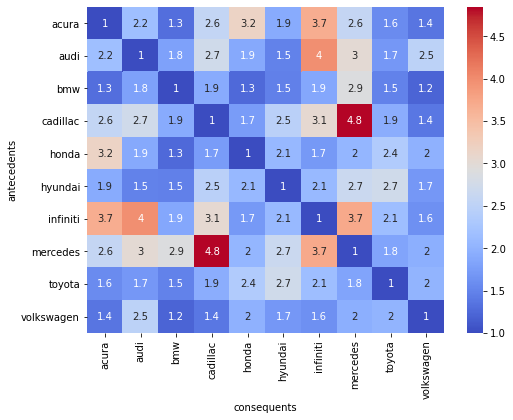

In [21]:
# creating pivot lift pivot
lift_pivot = rules_one_brand.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='mean')

# filling NaNs for diagonal terms
for i in range(len(lift_pivot)):
    lift_pivot.iloc[i, i] = 1
    
# filling non occuring words lifts with 0.5 for MDS
lift_pivot.fillna(0.5, inplace=True)

# heatmap for brand-brand occurences
plt.figure(figsize=(8,6))
sns.heatmap(lift_pivot, annot=True, cmap='coolwarm')

In [22]:
# COMMENTING OUT - GETTING SAME RESULTS FROM LIBRARY AS WELL
# lift calculation via dot product
# x = brand_occurence_df.iloc[:, 2:]

# brand_names = x.columns
# lift_matrix = pd.DataFrame(np.zeros((len(brand_names), len(brand_names))))
# lift_matrix.columns = brand_names
# lift_matrix.index = brand_names

# for i in brand_names:
#     print(i)
#     a = brand_occurence_df.loc[:, i].values
#     for j in brand_names:
#         b = brand_occurence_df.loc[:, j].values
#         print(len(brand_occurence_df), np.dot(a, b), np.sum(a), np.sum(b))
#         lift_matrix.loc[i, j] = len(brand_occurence_df) * np.dot(a, b)/np.sum(a)/np.sum(b)
#     lift_matrix.loc[i, i] = 0.5 

# lift_matrix.replace(0, 0.5, inplace=True)
# lift_matrix

## Task D - MDS

In [23]:
def get_mds(lift_matrix):
    
    # calculating dissimilarity matrix
    similarity_matrix = lift_matrix.values
    dissimilarity_matrix = 1/similarity_matrix

    for i in range(len(lift_pivot)):
        dissimilarity_matrix[i, i] = 0

    # getting cordinates for MDS
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=10,
                       dissimilarity="precomputed", n_jobs=1)

    pos = mds.fit_transform(dissimilarity_matrix)
    print('position of the each brand in MDS' , pos)

    # plotting MDS
    fig = plt.figure(1)
    ax = plt.axes([0., 0., 1., 1.])

    s = 100
    plt.scatter(pos[:, 0], pos[:, 1], color='navy', s=s, lw=0,
                label='True Position')
    for i in range(len(lift_matrix)):
        plt.text(pos[i, 0] - 0.05, pos[i, 1] - 0.05, lift_matrix.columns[i])
    plt.title('MDS plot for Top 10 Brands')
    plt.show()
    
    return 0


position of the each brand in MDS [[-0.07258689 -0.3477009 ]
 [-0.0811838   0.23122363]
 [-0.46813171  0.23531118]
 [-0.2407297  -0.12675396]
 [ 0.22478609 -0.32620214]
 [ 0.26842623 -0.10698401]
 [-0.08346298 -0.04364419]
 [-0.17366803  0.03411793]
 [ 0.36218805  0.06242872]
 [ 0.26436272  0.38820374]]


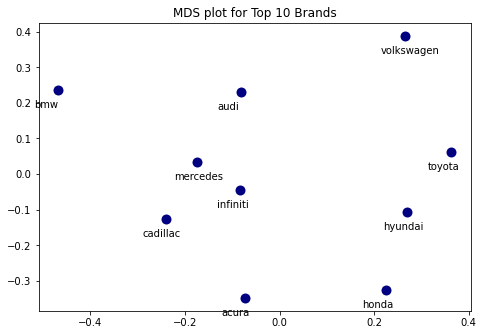

0

In [24]:
# refs - https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html
from sklearn import manifold

get_mds(lift_pivot)

## Task E - Interpretation and Insights from C/D

## Task F - Attribute analysis

In [25]:
import nltk 
nltk.download('averaged_perceptron_tagger')

# tagging pos to get noun words for attributes
text_pos_tag = nltk.pos_tag(token_cleaned_df['words'])
nn_text_pos = [w for w, t in text_pos_tag if t == 'NN']

# got word freq of nouns
nn_mask = token_cleaned_df['words'].isin(nn_text_pos)
token_nn_df = token_cleaned_df[nn_mask]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
# token_nn_df.head(60)

<BarContainer object of 5 artists>

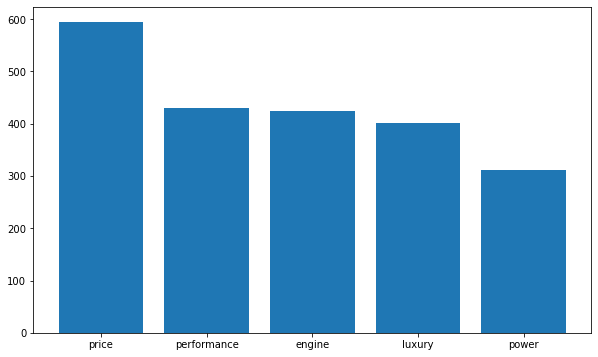

In [27]:
# based on eyeballing top attributes are below
attributes = ['price', 'performance', 'engine', 'luxury', 'power',
              'class', 'service', 'transmission', 'steering', 'torque']
# price, money, cost, msrp
# torque, power, engine
top5_attributes = attributes[:5]

# plot 
top5_attributes_freq = token_nn_df.loc[token_nn_df['words'].isin(top5_attributes), ['words', 'frequency']]
plt.figure(figsize=(10, 6))
plt.bar(top5_attributes_freq['words'], top5_attributes_freq['frequency'])

In [28]:
# creating attribute wise columns to get occurence into a dataframe
attribute_occurence_df = pd.DataFrame(np.zeros((data.shape[0], 5)))
attribute_occurence_df.columns = top5_attributes

# appending comment df with attribute occurence df
attribute_occurence_df = pd.concat([data, attribute_occurence_df], axis=1)

# geting occurence columns populated
for a in top5_attributes:
    print('calculating occurence in comment for brand - ', a)
    attribute_occurence_df[a] = attribute_occurence_df['comment'].str.contains(a).astype(int)

print(attribute_occurence_df.head())

calculating occurence in comment for brand -  price
calculating occurence in comment for brand -  performance
calculating occurence in comment for brand -  engine
calculating occurence in comment for brand -  luxury
calculating occurence in comment for brand -  power
              date                                            comment  price  \
0  2/26/2014 21:51  '02 rx300. gonna sit back, smell the oil and c...      0   
1   2/27/2014 2:45  @markcincinnati - like i mentioned i got the 1...      0   
2   2/27/2014 2:57  @stickguy i like the new feature to add pix- b...      0   
3  2/27/2014 14:59  @sweendogy: i read an article about the "indiv...      0   
4  2/27/2014 15:08  my wife's mazda cx-7 does that as well ... wil...      0   

   performance  engine  luxury  power  
0            0       0       0      0  
1            1       1       0      0  
2            0       0       0      0  
3            1       1       0      0  
4            0       0       0      0  


price          579
performance    322
engine         439
luxury         289
power          328
dtype: int64


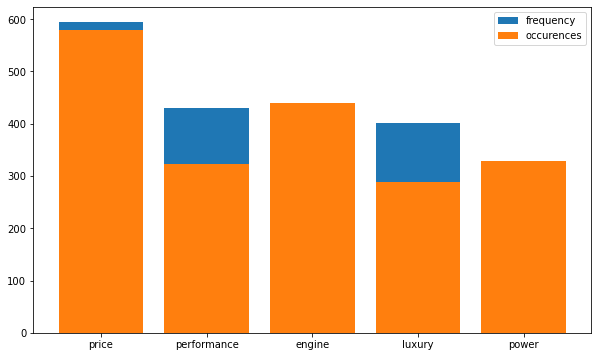

In [29]:
# CHECK
# testing the total occurence by attribute in comments vs total frequency in complete text 
comment_mentions = attribute_occurence_df.iloc[:, 2:].sum()
print(comment_mentions)

plt.figure(figsize=(10, 6))
plt.bar(top5_attributes_freq['words'], top5_attributes_freq['frequency'], label='frequency')
plt.bar(comment_mentions.index, comment_mentions, label='occurences')
plt.legend()

In [30]:
# CHECK
# nrows of both attribute_occurence_df and brand_occurence_df
assert len(brand_occurence_df) == len(attribute_occurence_df)

In [31]:
# creating data frame for brand attribute lift
brand_attribute_lift = pd.DataFrame(np.zeros((len(top10_brands), len(top5_attributes))))
brand_attribute_lift.index = top10_brands['Brand'].values
brand_attribute_lift.columns = top5_attributes

for i in brand_attribute_lift.index:
    b = brand_occurence_df.loc[:, i].values
    
    for j in brand_attribute_lift.columns:
        a = attribute_occurence_df.loc[:, j].values
        print(len(brand_occurence_df), np.dot(a, b), np.sum(a), np.sum(b))
        brand_attribute_lift.loc[i, j] = len(brand_occurence_df) * np.dot(a, b)/np.sum(a)/np.sum(b)

# brand_attribute_lift.replace(0, 0.5, inplace=True)
brand_attribute_lift

5000 186 579 861
5000 119 322 861
5000 144 439 861
5000 94 289 861
5000 106 328 861
5000 216 579 976
5000 115 322 976
5000 139 439 976
5000 97 289 976
5000 118 328 976
5000 95 579 476
5000 66 322 476
5000 82 439 476
5000 66 289 476
5000 58 328 476
5000 119 579 541
5000 63 322 541
5000 84 439 541
5000 62 289 541
5000 74 328 541
5000 66 579 235
5000 43 322 235
5000 37 439 235
5000 44 289 235
5000 25 328 235
5000 46 579 261
5000 28 322 261
5000 48 439 261
5000 25 289 261
5000 36 328 261
5000 56 579 180
5000 27 322 180
5000 23 439 180
5000 37 289 180
5000 14 328 180
5000 36 579 200
5000 27 322 200
5000 27 439 200
5000 23 289 200
5000 17 328 200
5000 50 579 192
5000 15 322 192
5000 27 439 192
5000 29 289 192
5000 22 328 192
5000 61 579 314
5000 38 322 314
5000 49 439 314
5000 31 289 314
5000 48 328 314


,price,performance,engine,luxury,power
audi,1.865526,2.146139,1.904868,1.888847,1.876717
bmw,1.911153,1.829625,1.622073,1.719468,1.843013
acura,1.723487,2.153035,1.962060,2.398883,1.857450
honda,1.899508,1.808246,1.768428,1.982744,2.085118
mercedes,2.425311,2.841285,1.793244,3.239343,1.621692
volkswagen,1.521979,1.665834,2.094625,1.657188,2.102607
cadillac,2.686624,2.329193,1.455328,3.556324,1.185637
infiniti,1.554404,2.096273,1.537585,1.989619,1.295732
hyundai,2.248849,1.213121,1.601651,2.613178,1.746697
toyota,1.677612,1.879179,1.777346,1.708064,2.330278


In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(brand_attribute_lift.T, annot=True, cmap='coolwarm')

<AxesSubplot:>

## Task G - Interpretation and Insights from E

## Task H - Aspirational brands

How to identify most aspirational brand - 
1. Identify words synonymus to aspiration from online dictionary
2. look for bigrams with such words most common and relevant in the available text based on eyeballing - top 10
3. Calculate lifts with those with top 10 brands 
4. Calculate average lift to identify most aspirational brand

In [ ]:
# looking basic word frequency that can be associated with aspirational
first_list = ['wish', 'want', 'aspire', 'hope', 'dream', 'desire', 'aim', 'long', 'look', 'plan']
text_token_df[text_token_df['words'].isin(first_list)]

In [ ]:
from nltk.util import ngrams
 
# Function to generate n-grams from sentences.
def extract_ngrams(token, num=2):
    n_grams = ngrams(token, num)
    return [ ' '.join(grams) for grams in n_grams]
 
text_bigram_counter = Counter(extract_ngrams(text_token))

# creating dataframe for frequency table
text_bigram_df = pd.DataFrame(data=None, columns=['words', 'frequency'])
text_bigram_df['words'] = text_bigram_counter.keys()
text_bigram_df['frequency'] = text_bigram_counter.values()

text_bigram_df.sort_values('frequency', inplace=True, ascending=False)
text_bigram_df.head()

In [ ]:
# getting bigrams from look
text_bigram_df[text_bigram_df['words'].str.contains('want')].head(10)

In [ ]:
# getting bigrams from want
text_bigram_df[text_bigram_df['words'].str.contains('look')].head(10)

In [ ]:
# getting bigrams from long
text_bigram_df[text_bigram_df['words'].str.contains('long')].head(10)

In [ ]:
# getting bigrams from hope
text_bigram_df[text_bigram_df['words'].str.contains('hope')].head(10),\
text_bigram_df[text_bigram_df['words'].str.contains('hoping')].head(10)

In [ ]:
# getting bigrams from wish
text_bigram_df[text_bigram_df['words'].str.contains('wish')].head(10)

In [ ]:
# getting bigrams from plan
text_bigram_df[text_bigram_df['words'].str.contains('plan')].head(10)

In [ ]:
# getting bigrams from dream
text_bigram_df[text_bigram_df['words'].str.contains('dream')].head(10)

In [ ]:
# getting bigrams from aspire
text_bigram_df[text_bigram_df['words'].str.contains('aspire')].head(10)

In [ ]:
# getting bigrams from aim
text_bigram_df[text_bigram_df['words'].str.contains('aim')].head(10)

In [ ]:
# final aspirational phrases list and their total frequency
aspirational_list = ['want to', 'you want', 'i want', 'i wanted', 
                     'looking for',
                     'i hope',
                     'i wish',
                     'i plan', 'plan to',
                     'dream car', 'dream machine', 'dream collection',
                     'aspire to']
text_bigram_df[text_bigram_df['words'].isin(aspirational_list)]['frequency'].sum()

In [ ]:
# using the brand_occurence_df to get the aspiration phrases list occurences
brand_occurence_df['aspirational'] = brand_occurence_df['comment'].str.findall(
    '( ' + '|'.join(aspirational_list) + ' )').astype(bool).astype(int)
brand_occurence_df['aspirational'].sum()

In [ ]:
# calculating lifts
# creating data frame for brand attribute lift
aspirational_lift = pd.DataFrame(np.zeros((len(top10_brands), 1)))
aspirational_lift.index = top10_brands['Brand'].values
aspirational_lift.columns = ['aspirational_lift']

for i in aspirational_lift.index:
    b = brand_occurence_df.loc[:, i].values
    a = brand_occurence_df.loc[:, 'aspirational'].values
    print(len(brand_occurence_df), np.dot(a, b), np.sum(a), np.sum(b))
    aspirational_lift.loc[i, 'aspirational_lift'] = len(brand_occurence_df) * np.dot(a, b)/np.sum(a)/np.sum(b)

aspirational_lift.sort_values('aspirational_lift', inplace=True, ascending=False)
aspirational_lift